# Adversarial Examples - googleNet on ImageNet



In [2]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset
import torch.nn.functional as F
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)

from IPython.display import clear_output

## 1. Load data and model

First we load the model and data.


### 1.1 Model

We use the trained googleNet [2]. It is available through the `Torchvision` library. It expects the data to be 3 channel RGB with a size of at least 224. The data has to be scaled into the range $[0, 1]$ and then centered, see [here](https://pytorch.org/hub/pytorch_vision_googlenet/). These steps are implemented in 1.2.

In [3]:
## Load model and data
model = models.googlenet(pretrained=True)
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [4]:
def idx_to_name(idx):
    '''
    Converts the output class index from the googleNet to the respective name.
    
    Input:
    idx  -- Class index as integer
    
    Returns:
    name -- Class names corresponding to idx as string
    '''
    
    ## Load dictionary from file    
    names = pd.read_csv("./data/ImageNet_subset/categories.csv")
    
    ## Retrieve class name for idx
    name = names.iloc[idx]["CategoryName"]
    
    return name

### 1.2 Data

As data we use the development set from [3]. It is a subset similar to the ImageNet dataset [4] on which the model from 1.1 is trained. It consists of only 1000 images of various classes. That means the dataset is small enough to be handled on a cpu.

The data can be obtained from the competition [NIPS 2017: Adversarial Learning Development Set](https://www.kaggle.com/google-brain/nips-2017-adversarial-learning-development-set#categories.csv) which was hosted on [Kaggle](http://www.kaggle.com).

In [5]:
class ImageNetSubset(Dataset):
    '''Imports subset of the ImageNet dataset from the Kaggle competion'''
    
    def __init__(self, csv_file, root_dir, transform=None):
        '''
        Args:
        csv_file (string)              -- Path to the csv file with metadata like labels and fileId.
        root_dir (string)              -- Directory with all the images.
        transform (callable, optional) -- Optional transform to be applied on a sample.
        '''

        self.images_meta = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
               
    def __len__(self):
        return len(self.images_meta)
    
    def __getitem__(self, idx):     
        image_path = self.root_dir
        image_name = self.images_meta["ImageId"][idx]
        label = self.images_meta["TrueLabel"][idx]
         
        ## Load image
        image = Image.open(image_path + image_name + ".png")
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [6]:
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

**Preprocess data**

The image has to be cropped, centered as well as normalized. Since the model has been trained with mini batch gradient descent, we add the batch dimension.

In [7]:
def tensor_to_image(tensor):
    '''
    De-normalizes an image as a tensor and converts it back into an 8bit image object.
    
    Inputs:
    tensor -- PyTorch tensor of shape (3, 224, 224)
    
    Returns:
    image  -- De-normalized image object
    '''
    
    ## De-normalize tensor image
    invert_preprocess = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
    ])
      
    image = invert_preprocess(tensor)      
    image = np.array(image.detach())
    
    ## Rescale to range 0-255 and convert datatype into 8bit
    image = image * 255    
    image = np.uint8(image)
    
    ## Swap axes to get the expected shape (224, 224, 3)
    image = np.swapaxes(image, 0, 2)
    
    ## Rotate image and convert to image object
    for i in range(3):
        image = np.rot90(image)
    
    image  = Image.fromarray(image)
    
    ## Show image
    plt.imshow(image)
        
    return image

## 2. Predict

In [8]:
def predict(model, image, target_label, return_grad=False, supress_output=True):
    '''
    Predicts the class of the image. Select supress_output=False to print out the 
    pedicted class and confidence score along with the provided label.
    
    Inputs:
    model           -- Trained neural net, here googleNet
    image           -- Preprocessed image as a torch tensor of shape (1, 3, 224, 224)
    target_label    -- Class target label as torch tensor of shape (1)
    
    Returns:
    gradient        -- None if return_grad=False. Otherwise the gradient from the prediction as a tensor.
    accuracy        -- Is 1 if correct, 0 if prediction is wrong.
    confidence      -- Confidence of prediction.
    '''
    
    ## Adjust target label to be 0 indexed to match output of googleNet
    target_label = target_label - 1
    
    ## Move to GPU if available
    if torch.cuda.is_available():
        image = image.to('cuda')
        model.to('cuda')
        print("Cuda available!")
      
    if return_grad == True:
        image.requires_grad=True
        prediction = model(image)
               
        # Zero gradients
        model.zero_grad()

        # Calculate loss
        loss = F.nll_loss(prediction, target_label)
        loss.backward()
        gradient = image.grad.data
        
    else:           
        gradient = None
        with torch.no_grad():
            prediction = model(image)
    
       
    ## Compute if prediction is correct or not.
    predicted_label = np.argmax(prediction.detach().numpy())
    target_label = target_label.squeeze().numpy() 
       
    if predicted_label == target_label:
        accuracy = 1.0
    else:
        accuracy = 0.0
     
    ## Get class index and confidence
    prediction = torch.nn.functional.softmax(prediction[0].detach(), dim=0).numpy()    
    confidence = prediction[predicted_label] * 100
    
    ## Get class name from the predicted index
    name = idx_to_name(predicted_label)
    
    ## Print info if selected
    if supress_output == False:
        print("Predicted class:\t{}\nActual class: \t\t{}\n{:.2f} % confidence\n-------".format(predicted_label, target_label, confidence))
        print("Predicted class name: " + str(name))
        
    
    return gradient, accuracy, confidence/100

## 3. Generate Adversarial Examples

Fast Gradient Sign Method [1]

$\widetilde{x} = x + \eta$

$\eta = \epsilon \cdot sign(\nabla_{x} J(\Theta, x, y))$



In [9]:
def generate_adversarial_fgsm(image, epsilon, grad_x):
    '''
    Generates adversarial image from the input image using the Fast Gradient Sign Method (FGSM).
    
    Inputs:
    image       -- Image data as tensor
    epsilon     -- Hyperparameter
    grad_x      -- Gradient of the cost with respect to x
    
    Returns:
    image_tilde -- Adversarial image as tensor
    '''
    
    ## Compute eta part
    eta = epsilon * grad_x.sign()
    
    ## Apply perturbation
    image_tilde = image + eta    
    
    ## Clip image to maintain the range [0, 1]
    image_tilde = torch.clamp(image_tilde, image.detach().min(), image.detach().max())
    
    return image_tilde

## 4. Run Attacks

## 4.1 Fast Gradient Sign Method

This method by [1] generates adversarial examples quickly. It computes a step of gradient descent and moves one step of magnitude $\epsilon$ into the direction of this gradient:

$\widetilde{x} = x + \eta$

$\eta = \epsilon \cdot sign(\nabla_{x} J(\Theta, x, y))$

This method computes examples quickly where $\epsilon$ is a hyperparameter. Let's inspect a few clean and perturbed examples for small and large values.

In [10]:
def plot_example(image_as_tensor, target_label, epsilon):
    '''
    Plots the clean and adversarial image.
    
    Inputs:
    image_as_tensor -- Image as tensor of shape (3, 224, 224)
    target_label    -- Label of target class as integer
    epsilon         -- FGSM hyperparameter as float
    '''
    
    ## Convert target label to torch tensor
    target_label = torch.tensor(target_label, dtype=torch.long).unsqueeze(0)
    
    ## Predict with clean example
    gradient, _, _ = predict(model, image_as_tensor.unsqueeze(0), target_label, return_grad=True, supress_output=False)

    print("\n==============================\nPerturbed image: \n")

    ## Generate adversarial example and predict
    perturbed_data = generate_adversarial_fgsm(image_as_tensor, epsilon, gradient)
    predict(model, perturbed_data, target_label, return_grad=False, supress_output=False)
  
    ## Plots
    plt.subplot(121)
    plt.title("Clean example", fontsize=30)
    tensor_to_image(image_as_tensor)
    plt.subplot(122)
    plt.title("Adversarial example", fontsize=30)
    tensor_to_image(perturbed_data.squeeze(0))

Predicted class:	472
Actual class: 		472
80.08 % confidence
-------
Predicted class name: canoe

Perturbed image: 

Predicted class:	693
Actual class: 		472
7.41 % confidence
-------
Predicted class name: paddle, boat paddle


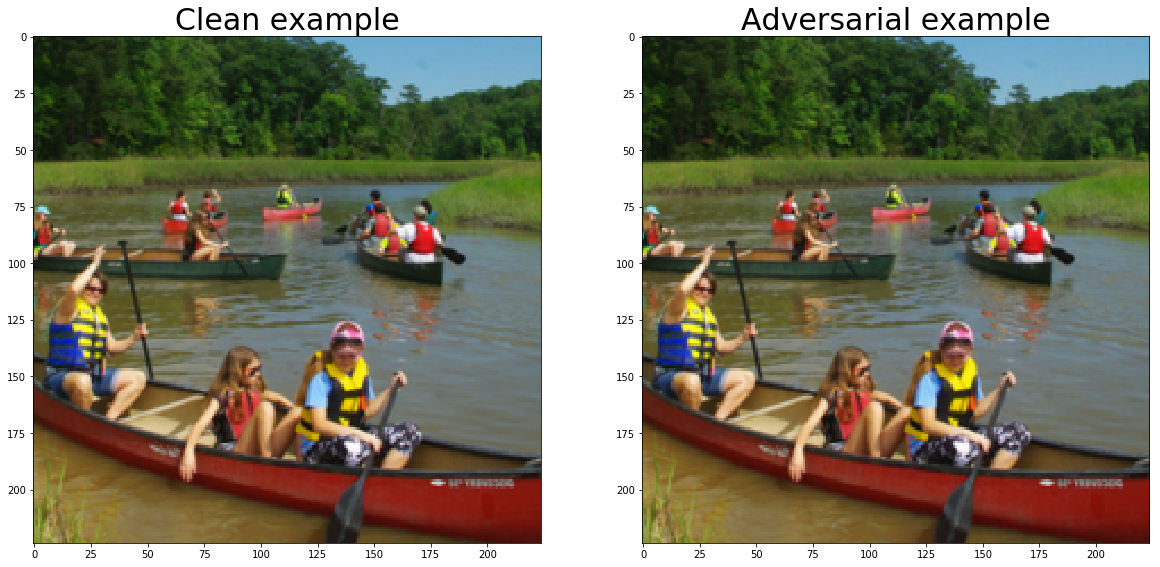

In [16]:
## Random example for smaller epsilon
epsilon = 4/255
idx = 440

image_as_tensor, target_label = data_loader.dataset[idx]
plot_example(image_as_tensor, target_label, epsilon)

Predicted class:	472
Actual class: 		472
80.08 % confidence
-------
Predicted class name: canoe

Perturbed image: 

Predicted class:	814
Actual class: 		472
3.44 % confidence
-------
Predicted class name: speedboat


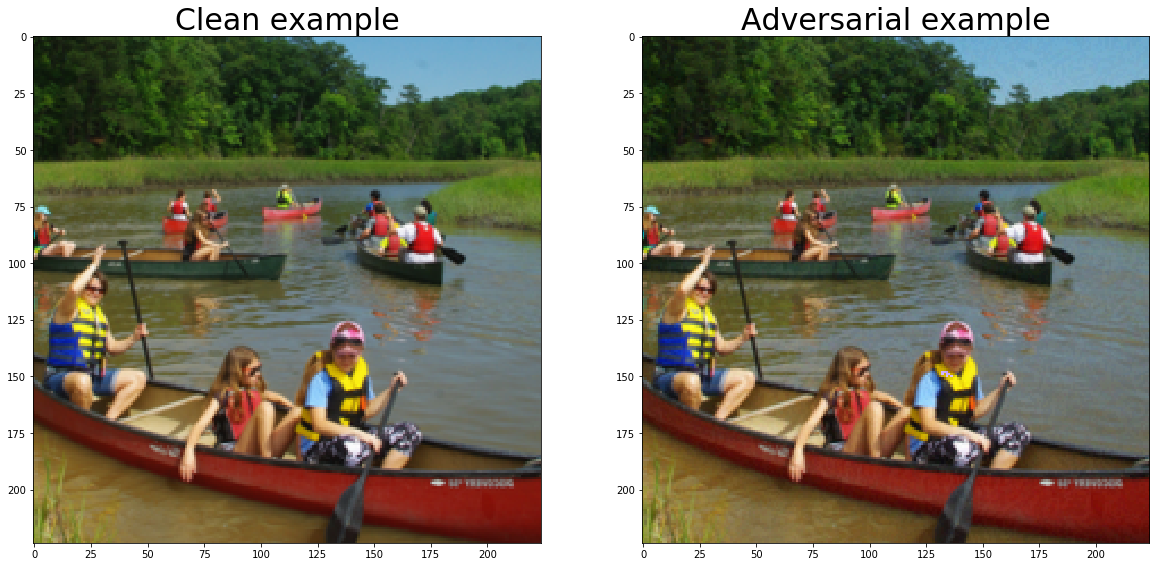

In [18]:
## Random example for larger epsilon
epsilon = 12/255
idx = 440

image_as_tensor, target_label = data_loader.dataset[idx]
plot_example(image_as_tensor, target_label, epsilon)

It can be seen that from a value of around $\epsilon = \frac{10}{255}$ the pertubation becomes visible to the human eye. Note that the model predicts a different class here with a very low confidence.

In [13]:
## Run on all 10000 examples
epsilons = [0, 2/255, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255, 90/255]

accuracy = []
confidence = []

accuracy_adversarial = []
confidence_adversarial = []

for epsilon in epsilons:
   
    acc_sub = []
    conf_sub = []
    acc_sub_adver = []
    conf_sub_adver = []
    i = 1
    
    for image_as_tensor, label in data_loader:      
        clear_output(wait=True)
        print("Running for epsilon {:.2f}".format(epsilon))
        print(i)
        print(np.mean(acc_sub_adver))
        
        ## Predict with clean image
        gradient, acc, conf = predict(model, image_as_tensor, label, return_grad=True)
        acc_sub.append(acc)
        conf_sub.append(conf)

        ## Predict with adversarial image
        perturbed_data = generate_adversarial_fgsm(image_as_tensor, epsilon, gradient)
        _, acc, conf = predict(model, perturbed_data, label)
        acc_sub_adver.append(acc)
        conf_sub_adver.append(conf)
        i += 1
        
    ## Add accuracies and confidences for clean and adversarial example
    accuracy.append(np.mean(acc_sub))
    confidence.append(np.mean(conf_sub))
    accuracy_adversarial.append(np.mean(acc_sub_adver))
    confidence_adversarial.append(np.mean(conf_sub_adver))

    
## Save results
result = pd.DataFrame()
e = np.array(epsilons) * 255
result["Epsilon_255"] = e
result["Accuracy"] = accuracy_adversarial
result["Confidence"] = confidence_adversarial
#result.to_csv("results/googleNet_ImageNet_FGSM.csv")

Running for epsilon 0.35
1000
0.8438438438438438


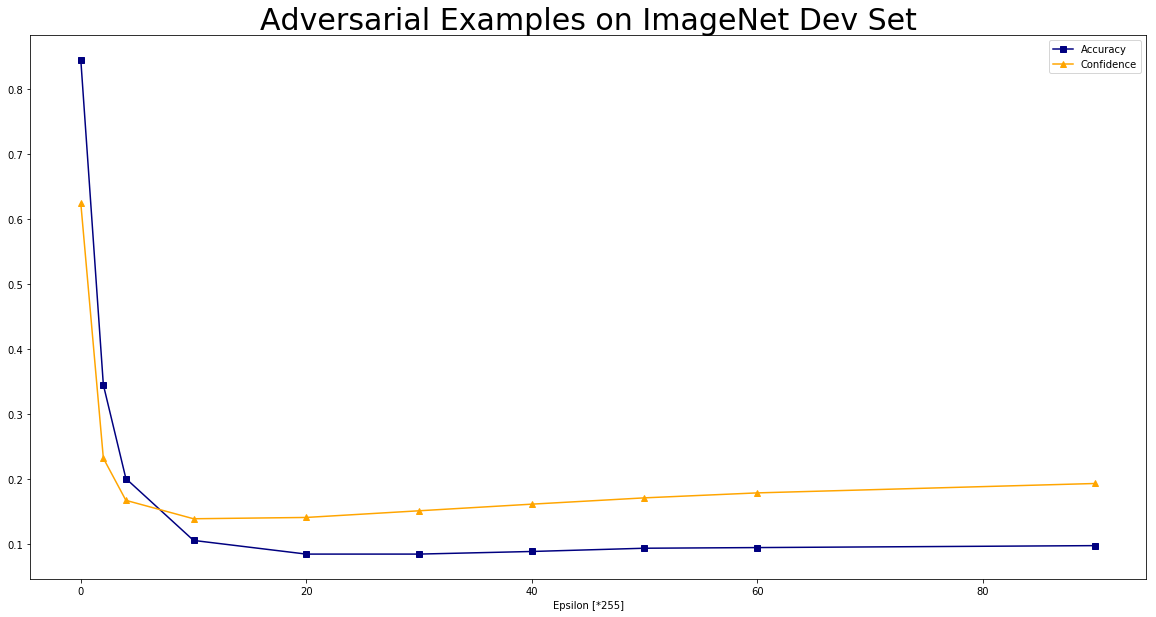

In [14]:
plt.plot(e, accuracy_adversarial, "s-", color="navy", label="Accuracy")
plt.plot(e, confidence_adversarial, "^-", color="orange", label="Confidence")
plt.xlabel("Epsilon [*255]")

plt.title("Adversarial Examples on ImageNet Dev Set", fontsize=30)
plt.legend()
#plt.show()

#plt.savefig("./plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_FGSM.pdf")
#plt.savefig("./plots/googleNet_ImageNet/Adversarial_Examples_ImageNet_FGSM.png")

## 5. Conclusions

The average accuracy drops quickly for even small values of $\epsilon$. So does the confidence. Interestingly, the confidence increases slightl with increasing $\epsilon$ after droping singificantly at the beginning.


## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*

[2] &emsp; Szegedy et al. (2015) *Going Deeper with Convolutions*

[3] &emsp; Kurakin et al. (2018) *Adversarial Attacks and Defences Competition*

[4] &emsp; Russakovsky et al. (2015) *ImageNet Large Scale Visual Recognition Challenge*
